# Машинное обучение. ВМК МГУ
## Практическое задание 9: Частичное Обучение. Методы снижения размерности.

### Важно! О формате сдачи

* **Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **В этом ноутбуке есть задание на unit-тестирование**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулировке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

**А также..**

Если в ячейке написана фраза `Ваш ответ здесь: (ｏ・_・)ノ”(ノ_<、)`, то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано `# Ваш код здесь:＼(º □ º l|l)/`, то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой `Ваш ответ здесь: (ｏ・_・)ノ”(ノ_<、)`, и ячейка с фразой `# Ваш код здесь:＼(º □ º l|l)/`, то в ответе ожидается и код, и текст)

**В этом задании вы..:**

* Познакомитесь с одним способом визуализации процесса обучения
* Сравните между собой результаты разных способов кластеризации
* Посмотрите и реализуете несколько метрик качества кластеризации
* Попробуете разные методы снижения размерности

### *Примерное время выполнения (run all) всех ячеек ноутбука: 60 минут*

-----------------------------

Если вы работаете с ноутбуком <font color='red'>локально</font>, то перед началом выполнения переведите ноутбук в `Доверенный режим` (`Trusted`) для корректного отображения изображений:

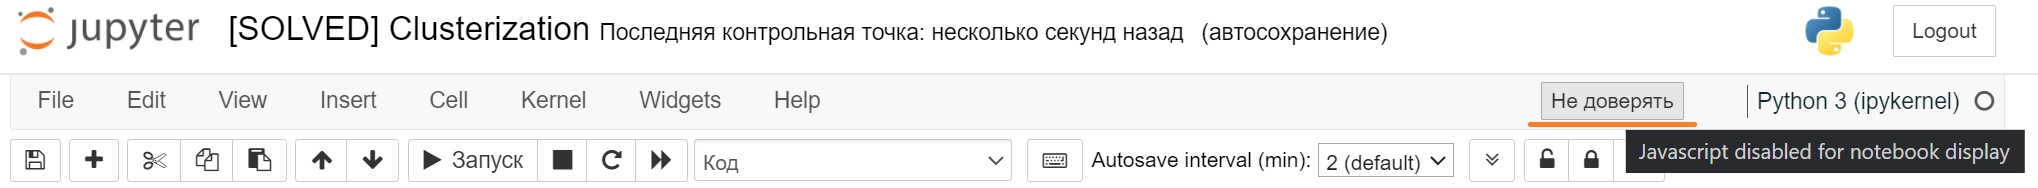

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

## Установка в Google Colab
Если вы используете Google Colab, то вам достаточно установить библиотеки с помощью ячейки ниже. 

После установки нужных версий нажмите на кнопку `Restart runtime`, которая появится в следующей ячейке после завершения ее выполнения.

После перезапуска (`Restart runtime`) устанавливать библиотеки еще раз не нужно, достаточно проверить, что установилась их новая версия.

**Важно!** 
Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

**Обратите внимание, что установка `torch` и `tensorflow` через `pip` может сломать ваше окружение, особенно если вы используете GPU. Выполняйте их установку в соответствии с Вашей конфигурацией системы или в отдельном виртуальном окружении**

Внимание! Ячейка перезапускает рантайм для учета обновления библиотек!

Тот же файл ссылкой: https://drive.google.com/file/d/1emagLwrQrZoaitHvoRkp2ZOFNg0TsZdR/view?usp=share_link

In [ ]:
!pip install --upgrade --no-cache-dir gdown 
!gdown 1emagLwrQrZoaitHvoRkp2ZOFNg0TsZdR

!pip install -r /content/requirements2.txt

if 'google.colab' in str(get_ipython()):
    import IPython, ipywidgets, google

    button = ipywidgets.Button(
        description='Нажмите, чтобы перезапустить Google Colab Runtime',
        layout=ipywidgets.Layout(width='auto', height='40px')
    )        
    button.on_click(lambda _: get_ipython().kernel.do_shutdown(True))
    IPython.display.display(button)

In [1]:
import matplotlib
assert(matplotlib.__version__ == '3.5.3')

# 0. Введение.

## 0.1 О задании

В данной работе вам будет предложено применить кластеризацию и снижение размерности в задачах **Частичного Обучения** (Semi-Supervised learning).

## 0.2 Необходимые библиотеки

Здесь перечислены основные функции и библиотеки, которые могут понадобиться Вам в процессе выполнения задания. Подключение других библиотек возможно, но нежелательно. **Работа каких-либо других библиотек не гарантируется.**

In [2]:
import warnings

import numpy as np

import tqdm.auto as tqdm

import scipy.spatial.distance

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from torchvision.datasets import MNIST

import sklearn

from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier

# Библиотека umap-learn, а не umap
from umap import UMAP

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

**Обратите внимание, что динамическое содержимое может некорректно сохраняться в jupyter notebook. Используйте его только для локальной визуализации. Все графики, необходимые для сдачи задания должны быть статическими. Переход в статический режим происходит с помощью магической команды `%matplotlib inline`.**

**<font color=red>Обязательно убедитесь, что все графики корректно отображаются после сдачи в систему.</font>** Для этого достаточно открыть загруженный в систему файл и, просмотрев его, убедиться, что все сохранилось корректно

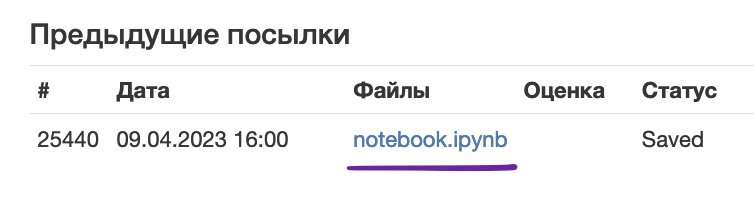

In [3]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 300

## 0.3 Ещё несколько важных замечаний

При выполнении задания <font color='red'>запрещено</font>:
1. Менять те seed, которые явно указаны в коде
2. Менять прототипы функций, классов, методов классов
3. Менять константы, используемые для генерации выборок

При оформлении задания обратите внимание на форматирование кода и на оформление графиков:

* Весь код должен быть оформлен в строгом соответствии с [PEP8](https://pep8.org/) (для юнит-тестов обязательно, для ноутбука очень желательно)

Графики должны быть с одной стороны понятными и информативными, а с другой стороны *красивыми*. Вот несколько пунктов, которые помогут удовлетворить этим требования:
1. Все графики должны быть отрисованы в **векторном формате**. Обратите внимание, что смена режима графиков с динамического на статический и обратно может приводить к сбросу параметров отрисовки графиков. Переход в векторный режим можно выполнить с помощью команды `matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')`. Если изображения в векторном формате приводят к слишком большому размеру Jupyter Notebook можете использовать растровые изображения с **высоким dpi**. Напирмер, можно установить глобальный dpi в matplotlib: `matplotlib.rcParams['figure.dpi'] = 300`
2. На всех графиках без исключения должна быть нарисована сетка
3. Все графики и группы графиков должны иметь заголовок (`title`)
4. При необходимости оси должны быть подписаны
5. Если на графике отображено несколько сущностей (линии/точки/bar разных цветов, формы и так далее), то необходима исчерпывающая легенда
6. Все линии на графиках должны быть чётко видны (нет похожих цветов или цветов, сливающихся с фоном и так далее)
7. Масштаб по каждой оси на графике должен быть выбран правильно. Используйте масштабы `log`, `symlog` по необходимости
8. Если отображена величина, имеющая очевидный диапазон значений (например, проценты могут быть от 0 до 100), то желательно масштабировать ось на весь диапазон значений (исключением является случай, когда вам необходимо показать малое отличие, которое незаметно в таких масштабах)
9. Частота отметок по каждой оси должна быть тщательно подобрана, по необходимости задавайте `[xy]ticks`, `[xy]ticklabels` вручную. Подписи тиков на осях не должны сливаться как на одной оси, так и между ними
10. Помните, что matplotlib умеет выполнять [рендеринг Latex](https://matplotlib.org/stable/gallery/text_labels_and_annotations/tex_demo.html). Используйте эту возможность для написания формул в заголовках, легенде и в подписях осей
11. Используйте *красивую* цветовую палитру с хорошо различимыми цветами. Примеры цветовых палитр можно посмотреть [здесь](https://matplotlib.org/stable/gallery/color/colormap_reference.html). При наличи особенностей восприятия цвета можно использовать специальные палитры:
```python
plt.style.use('seaborn-colorblind')
# Или
plt.style.use('tableau-colorblind10')
# Затем, при отрисовке графиков не используйте параметр cmap
```
12. Графики должны быть не супер-микро и не супер-макро по размерам, так, чтобы можно было увидеть все, что нужно

# 1. Частичное обучение.  [кросспроверка 10 баллов,  unittests 10 баллов]

В этой части мы рассмотрим применение алгоритмов снижения размерности и кластеризации в контексте задач классификации в постановке Semi-Supervised learning.

Рассмотрим задачу классификации изображений из датасета MNIST. Предположим, что известна только небольшая часть разметки по которой мы хотим обучить классификатор. В отличии от классических задач обучения с учителем здесь мы можем использовать большой объём неразмеченных объектов.

Будем далее считать, что неразмеченные объекты имеют метку $-1$.

Существует много вариантов решения данной задачи. Предлагается рассмотреть следующие из них:
1. Обучение модели, например, логистической регрессии на размеченной части
2. Методы SelfTraining, в частости `SelfTrainingClassifier` с логистической регрессией в качестве базовой модели
3. Использование кластеризации для определения групп похожих объектов и размеченной подвыборки для определения меток кластеров

Каждый из данных вариантов можно обучать на разных признаковых пространствах. Предлагается проверить, как методы снижения размерности будут влиять на качество итогового алгоритма. Нужно учесть, что не все алгоритмы снижения размерности допускают преобразование новых объектов в низкоразмерное пространство, поэтому предлагается сравнить `UMAP` с исходным признаковым пространством.

#### **Задание 1.1 [unittests, 10 баллов]** 

Реализуйте третью из предложенных моделей. Подробная спецификация и описание входных данных к тестам указаны в **описании задания (pdf)**.

**Замечание:** В данном пункте разрешено использовать `sklearn.cluster.KMeans`

In [4]:
import numpy as np

import sklearn
from sklearn.cluster import KMeans


class KMeansClassifier(sklearn.base.BaseEstimator):
    def __init__(self, n_clusters):
        '''
        :param int n_clusters: Число кластеров которых нужно выделить в обучающей выборке с помощью алгоритма кластеризации
        '''
        super().__init__()
        self.n_clusters = n_clusters

    def fit(self, data, labels):
        '''
        Функция обучает кластеризатор KMeans с заданным числом кластеров, а затем с помощью
        self._best_fit_classification восстанавливает разметку объектов

        :param np.ndarray data: Непустой двумерный массив векторов-признаков объектов обучающей выборки
        :param np.ndarray labels: Непустой одномерный массив. Разметка обучающей выборки. Неразмеченные объекты имеют метку -1.
            Размеченные объекты могут иметь произвольную неотрицательную метку. Существует хотя бы один размеченный объект
        :return KMeansClassifier
        '''
        self.kmeans = KMeans(
            n_clusters=self.n_clusters,
            n_init="auto",
            max_iter=750
        ).fit(data)
        self.cluster_labels = self.kmeans.labels_
        self.ground_truth_labels = labels
        self.mapping, self.predicted_labels = self._best_fit_classification(
            self.cluster_labels,
            self.ground_truth_labels
        )

        return self

    def predict(self, data):
        '''
        Функция выполняет предсказание меток класса для объектов, поданных на вход. Предсказание происходит в два этапа
            1. Определение меток кластеров для новых объектов
            2. Преобразование меток кластеров в метки классов с помощью выученного преобразования

        :param np.ndarray data: Непустой двумерный массив векторов-признаков объектов
        :return np.ndarray: Предсказанные метки класса
        '''
        data_labels = np.array(self.kmeans.predict(data))
        preds = np.zeros_like(data_labels)
        unique_labels = np.unique(data_labels)
        for unique_label in unique_labels:
            mask = data_labels == unique_label
            pred_cls = self.mapping[unique_label]
            preds[mask] = pred_cls

        return preds

    def _best_fit_classification(self, cluster_labels, true_labels):
        '''
        :param np.ndarray cluster_labels: Непустой одномерный массив. Предсказанные метки кластеров.
            Содержит элементы в диапазоне [0, ..., n_clusters - 1]
        :param np.ndarray true_labels: Непустой одномерный массив. Частичная разметка выборки.
            Неразмеченные объекты имеют метку -1. Размеченные объекты могут иметь произвольную неотрицательную метку.
            Существует хотя бы один размеченный объект
        :return
            np.ndarray mapping: Соответствие между номерами кластеров и номерами классов в выборке,
                то есть mapping[idx] -- номер класса для кластера idx
            np.ndarray predicted_labels: Предсказанные в соответствии с mapping метки объектов

            Соответствие между номером кластера и меткой класса определяется как номер класса с максимальным числом объектов
        внутри этого кластера.
            * Если есть несколько классов с числом объектов, равным максимальному, то выбирается метка с наименьшим номером.
            * Если кластер не содержит размеченных объектов, то выбирается номер класса с максимальным числом элементов в выборке.
            * Если же и таких классов несколько, то также выбирается класс с наименьшим номером
        '''
        true_labels_np = np.array(true_labels)
        cluster_labels_np = np.array(cluster_labels)
        unique_labels, label_counts = np.unique(true_labels_np[true_labels_np != -1], return_counts=True)
        max_amount_label = unique_labels[np.argmax(label_counts)]
        all_cluster_labels_np = np.unique(cluster_labels_np)
        mapping = np.full(shape=(self.n_clusters), fill_value=-1, dtype=np.int64)
        for cluster_label in all_cluster_labels_np:
            mask = cluster_labels_np == cluster_label
            true_cluster_labels = true_labels_np[mask]
            if len(true_cluster_labels[true_cluster_labels != -1]) == 0:
                cluster_label_predicted = max_amount_label
            else:
                unique, counts = np.unique(true_cluster_labels[true_cluster_labels != -1], return_counts=True)
                cluster_label_predicted = unique[np.argmax(counts)]
            true_labels_np[mask] = cluster_label_predicted
            mapping[cluster_label] = cluster_label_predicted

        mapping[mapping == -1] = max_amount_label

        return mapping, true_labels_np

Проверьте `KMeansClassifier._best_fit_classification` на простейших тестах:

In [5]:
def all_equal(list_left, list_right):
    assert np.all([np.all(left == right) for left, right in zip(list_left, list_right)])

all_equal(
    KMeansClassifier(10)._best_fit_classification(
        np.array([2, 2, 2, 1, 1, 1, 0, 0, 0]),
        np.array([5, 5, 6, 8, 7, 6, 6, 7, 7]),
    ),
    (np.array([7, 6, 5, 6, 6, 6, 6, 6, 6, 6]), np.array([5, 5, 5, 6, 6, 6, 7, 7, 7]))
)

all_equal(
    KMeansClassifier(10)._best_fit_classification(
        np.array([ 4,  4,  4, 1, 1, 1, 2, 2, 2, 3, 3, 3,  0, 0,  0, 0,  0]),
        np.array([-1, -1, -1, 5, 5, 6, 8, 7, 6, 6, 7, 7, -1, 8, -1, 3, -1]),
    ),
    (np.array([3, 5, 6, 7, 6, 6, 6, 6, 6, 6]), np.array([6, 6, 6, 5, 5, 5, 6, 6, 6, 7, 7, 7, 3, 3, 3, 3, 3]))
)

print('OK')

OK


Теперь создадим модель которая будет объединять все вышеописанные способы решения задачи Semi-Supervised learning.

#### **Задание 1.2 [код]** 

Реализуйте модель, которая в зависимости от параметра `data_processing` будет выполнять то или иное преобразование признакового пространства. Параметр `model` должен задавать одну из трёх описанных выше моделей поверх преобразованных данных. Вспомогательные аргументы нужно передавать через словари `reducer_kwargs`, `model_kwargs` (например, размерность пространства для методов снижения размерности, коэффициент регуляризации логистической регрессии, число кластеров KMeans и так далее).

*Замечание:* Большую часть времени работы модели (как обучения, как и предсказания) будет занимать преобразование признаков в низкоразмерное пространство с помощью UMAP. Если несколько способов, как ускорить данный процесс:
1. Параметр `n_neighbors` у UMAP значительно влияет на скорость работы. Можно установить его меньше, чем по умолчанию (не желательно ставить его меньше $5-7$). Попробуйте подобрать этот параметр в зависимости от качества визуализации в задании **1.3**
2. Так как UMAP метрический алгоритм, он требует большого числа вычислений попарных расстояний между точками. При выполнении перебора гиперпараметров в заданиях ниже можно значительно сэкономить, предподсчитав попарное расстояние между объектами для обучения и расстояние между объектам для предсказаний и объектами обучающей выборки. Используйте для работы в таком режиме `metric='precomputed'`. В таком режиме UMAP выдаёт ненужные warnings. Подавите их с помощью соответствующего контекст менеджера:
```python
with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Вызовы UMAP. __init__ / fit / fit_transform / transform
```
Не забудьте про масштабирование признаков

In [6]:
class MetaSemiSupervisedModel(sklearn.base.BaseEstimator):
    def __init__(self, data_processing, model, reducer_kwargs, model_kwargs):
        '''
        :param str data_processing: 
            Если data_processing == 'UMAP', то входные данные необходимо преобразовать с помощью данного алгоритма с
                числом компонент reducer_kwargs['n_components'].
            Опционально, используйте reducer_kwargs['metric'] для ускорения алгоритма с помощью предподсчитанной
                матрицы расстояний 
            Иначе, не преобразовывать входные данные
        :param str model:
            Если model == 'LogisticRegression', то использовать логистическую регрессию на размеченных данных
                и коэффициентом регуляризации model_kwargs['C']
            Если model == 'SelfTrainingClassifier', то использовать SelfTrainingClassifier с базовой моделью LogisticRegression
                и коэффициентом регуляризации model_kwargs['C']
            Если model == 'KMeansClassifier', то использовать KMeansClassifier с числом кластеров model_kwargs['n_clusters']
        :param dict reducer_kwargs:
        :param dict model_kwargs:
        '''
        super().__init__()
        
        if model == 'LogisticRegression':
            self.model = LogisticRegression(C=model_kwargs['C'])
            self.model_name = 'LogisticRegression'
        elif model == 'SelfTrainingClassifier':
            self.model = SelfTrainingClassifier(
                base_estimator=LogisticRegression(C=model_kwargs['C'])
            )
            self.model_name = 'SelfTrainingClassifier'
        elif model == 'KMeansClassifier':
            self.model = KMeansClassifier(model_kwargs['n_clusters'])
            self.model_name = 'KMeansClassifier'
        
        assert model in [
            'KMeansClassifier',
            'SelfTrainingClassifier',
            'LogisticRegression'
        ]
            
        self.reducer_kwargs, self.model_kwargs = reducer_kwargs, model_kwargs

        if data_processing == 'UMAP':
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                self.reducer = UMAP(
                    n_components=reducer_kwargs['n_components'],
                    metric=reducer_kwargs['metric']
                )
        else:
            self.reducer = None
        self.scaler = StandardScaler()

    def fit(self, data, labels):
        '''
        :param np.ndarray data: Непустой двумерный массив векторов-признаков объектов обучающей выборки. 
            Если reducer_kwargs['metric'] == 'precomputed', тогда @data квадратная матрица попарных расстояний между объектами
        :param np.ndarray labels: Непустой одномерный массив. Разметка обучающей выборки. Неразмеченные объекты имеют метку -1. 
            Размеченные объекты могут иметь произвольную неотрицательную метку. Существует хотя бы один размеченный объект
        :return MetaSemiSupervisedModel
        '''
        labels = np.array(labels)
        data = self.scaler.fit_transform(data)
        
        if not self.reducer is None:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                if self.reducer_kwargs['metric'] == 'precomputed':
                    data = pairwise_distances(data)
                self.processed_data_train = self.reducer.fit_transform(data)
        else:
            self.processed_data_train = data
        
        if self.model_name in ['SelfTrainingClassifier', 'KMeansClassifier']:
            self.model.fit(self.processed_data_train, labels)
        else:
            mask = labels != -1
            self.model.fit(
                self.processed_data_train[mask],
                labels[mask]
            )
        
    def predict(self, data):
        '''
        Функция выполняет предсказание меток класса для объектов, поданных на вход
        :param np.ndarray data: Непустой двумерный массив векторов-признаков объектов.
            Если reducer_kwargs['metric'] == 'precomputed', тогда @data прямоугольная матрица расстояний между
            каждым объектом для которого делается предсказание и каждым объектом обучающей выборки.
        :return np.ndarray: Предсказанные метки класса
        '''
        data = self.scaler.transform(data)

        if not self.reducer is None:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                if self.reducer_kwargs['metric'] == 'precomputed':
                    data = pairwise_distances(data)
                self.processed_data_test = self.reducer.fit_transform(data)
        else:
            self.processed_data_test = data

        predictions = self.model.predict(self.processed_data_test)
        
        return predictions

Загрузим датасет MNIST. Для ускорения перебора гиперпараметров, можете уменьшить число объектов в выборке. Не делайте это число менее $4000$.

In [7]:
mnist_n_objects = 4000

In [8]:
mnist_test_dataset = MNIST('./mnist', train=False, download=True)
mnist_train_dataset = MNIST('./mnist', train=True, download=False)

mnist_labels_test = np.array(mnist_test_dataset.targets)
mnist_labels_train = np.array(mnist_train_dataset.targets)

mnist_images_test = mnist_test_dataset.data.numpy()
mnist_images_train = mnist_train_dataset.data.numpy()

mnist_images_test, _, mnist_labels_test, _ = train_test_split(
    mnist_images_test, mnist_labels_test, 
    train_size=mnist_n_objects, stratify=mnist_labels_test, random_state=6886
)
mnist_images_train, _, mnist_labels_train, _ = train_test_split(
    mnist_images_train, mnist_labels_train, 
    train_size=mnist_n_objects, stratify=mnist_labels_train, random_state=6886
)

mnist_data_test = (mnist_images_test.astype(np.float32) / 255.0).reshape([mnist_images_test.shape[0], -1])
mnist_data_train = (mnist_images_train.astype(np.float32) / 255.0).reshape([mnist_images_train.shape[0], -1])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



#### **Задание 1.3 [код]** 

Примените метод снижения размерности на ваш вкус для новых данных и изобразите результат на графике. Используйте это представление для визуализации в дальнейшем.

*Замечание:* Не забудьте, что масштаб признаков существенно влияет на работу алгоритма снижения размерности.

*Замечание:* Для отрисовки низкоразмерных данных можно использовать функцию `plot_interactive`. Данная функция может работать и в интерактивном режиме, которым можно воспользоваться, если ваша среда выполнения его поддерживает. Не забудьте переключиться в статический режим после отрисовки динамического контента с помощью магической команды `%matplotlib inline`.

In [9]:
from ipywidgets import interactive, fixed, interact_manual, IntSlider, FloatLogSlider, FloatSlider
from sklearn.metrics import pairwise_distances

In [10]:
def plot_interactive(lowd_data, images, labels, names=None, n_dots=1000, image_scale=1.0):
    with matplotlib.rc_context(rc={
        'font.size': image_scale * matplotlib.rcParams['font.size'],
        'xtick.major.size': image_scale * matplotlib.rcParams['xtick.major.size'],
        'xtick.minor.size': image_scale * matplotlib.rcParams['xtick.minor.size'],
        'ytick.major.size': image_scale * matplotlib.rcParams['ytick.major.size'],
        'ytick.minor.size': image_scale * matplotlib.rcParams['ytick.minor.size'],
        
        'axes.linewidth': image_scale * matplotlib.rcParams['axes.linewidth'],
        'grid.linewidth': image_scale * matplotlib.rcParams['grid.linewidth'],
        'patch.linewidth': image_scale * matplotlib.rcParams['patch.linewidth'],
        'xtick.major.width': image_scale * matplotlib.rcParams['xtick.major.width'],
        'xtick.minor.width': image_scale * matplotlib.rcParams['xtick.minor.width'],
        'ytick.major.width': image_scale * matplotlib.rcParams['ytick.major.width'],
        'ytick.minor.width': image_scale * matplotlib.rcParams['ytick.minor.width'],
        
        'lines.markeredgewidth': image_scale * matplotlib.rcParams['lines.markeredgewidth'],
    }):
        fig, ax = plt.subplots(1, 1, figsize=(image_scale * 10, image_scale * 5))
        fig.set_dpi(300)
        ax.grid(True)

        n_clusters = len(np.unique(labels))

        scatter = plt.scatter(
            lowd_data[:n_dots, 0], lowd_data[:n_dots, 1], s=image_scale * 10, 
            c=labels[:n_dots], cmap=plt.get_cmap('tab20', n_clusters), edgecolors='none'
        )

        cbar = plt.colorbar(scatter, ax=ax, label='Название кластера')
        cbar.set_ticks(np.min(labels[:n_dots]) + (np.arange(n_clusters) + 0.5) * (n_clusters - 1) / n_clusters)
        #cbar.set_ticklabels(names)

        offset_image = OffsetImage(images[0], zoom=image_scale * 2.0)
        ann_bbox = AnnotationBbox(
            offset_image, (0,0), xybox=(image_scale * 50., image_scale * 50.), xycoords='data',
            boxcoords="offset points", pad=0.3, arrowprops=dict(
                arrowstyle='->, head_length={0:.2f}, head_width={1:.2f}'.format(
                    image_scale * 0.4, image_scale * 0.2
                )
            )
        )
        ax.add_artist(ann_bbox)
        ax.set_title('Распределение данных CIFAR10 в проекции на 2 случайные оси')
        ann_bbox.set_visible(False)

        def image_hover(event):
            if scatter.contains(event)[0]:
                ind, *_ = scatter.contains(event)[1]["ind"]
                w, h = fig.get_size_inches() * fig.dpi
                ws = (event.x > w / 2.) * -1 + (event.x <= w / 2.) 
                hs = (event.y > h / 2.) * -1 + (event.y <= h / 2.)
                ann_bbox.xybox = (image_scale * 50.0 * ws, image_scale * 50.0 * hs)
                ann_bbox.set_visible(True)
                ann_bbox.xy =(lowd_data[ind, 0], lowd_data[ind, 1])
                offset_image.set_data(images[ind])
            else:
                ann_bbox.set_visible(False)
            fig.canvas.draw_idle()

        fig.canvas.mpl_connect('motion_notify_event', image_hover) 

        plt.show()

In [ ]:
%matplotlib ipympl
matplotlib.rcParams['figure.dpi'] = 300

# Для работы в Google Colab нужно выполнить специфичную магию
# Обычно, она не срабатывает с первого раза, поэтому может потребоваться
#   несколько раз выполнить ячейку и несколько раз попробовать нарисовать график
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass

In [ ]:
best_params = {
    'C': None,
    'n_components': None,
    'n_clusters': None,
    'metric': None,
    'model_name': None
}

In [ ]:
def SemiSupervised_updater(
    train_data, labels, test_data,
    model_name, n_clusters, max_iter, C, 
    n_components, metric, data_processing
):
    
    model_kwargs = {
        'C': C,
        'n_clusters': n_clusters
    }
    reducer_kwargs = {
        'n_components': n_components,
        'metric': metric
    }
    
    SumeSupervisedModel = MetaSemiSupervisedModel(
        data_processing='UMAP',
        model=model_name,
        reducer_kwargs=reducer_kwargs,
        model_kwargs=model_kwargs
    )

    SumeSupervisedModel.fit(train_data, labels),
    preds = SumeSupervisedModel.predict(test_data)

    best_params['C'] = C
    best_params['n_components'] = n_components
    best_params['n_clusters'] = n_clusters
    best_params['model_name'] = model_name
    best_params['metric'] = metric

    plot_interactive(
        SumeSupervisedModel.processed_data_test,
        mnist_images_test,
        preds,
        image_scale=0.5
    )


interactive_SemiSupervised = interactive(
    SemiSupervised_updater, train_data=fixed(mnist_data_train), labels=fixed(mnist_labels_train), test_data=fixed(mnist_data_test),
    n_clusters=IntSlider(value=4, min=1, max=10, step=1, descrption=r'n_clusters'),
    max_iter=IntSlider(value=700, min=200, max=1200, step=50, descrption=r'max_iter'),
    C=[0.0001, 0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    model_name=['KMeansClassifier', 'SelfTrainingClassifier', 'LogisticRegression'],
    n_components=IntSlider(value=10, min=7, max=20, step=1, descrption=r'n_components'),
    metric=['precomputed', 'cosine', 'euclidean', 'manhattan'],
    data_processing=fixed('UMAP')
)
interactive_SemiSupervised

interactive(children=(Dropdown(description='model_name', options=('KMeansClassifier', 'SelfTrainingClassifier'…

Вернёмся в статичный режим отрисовки изображений:

In [ ]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 300

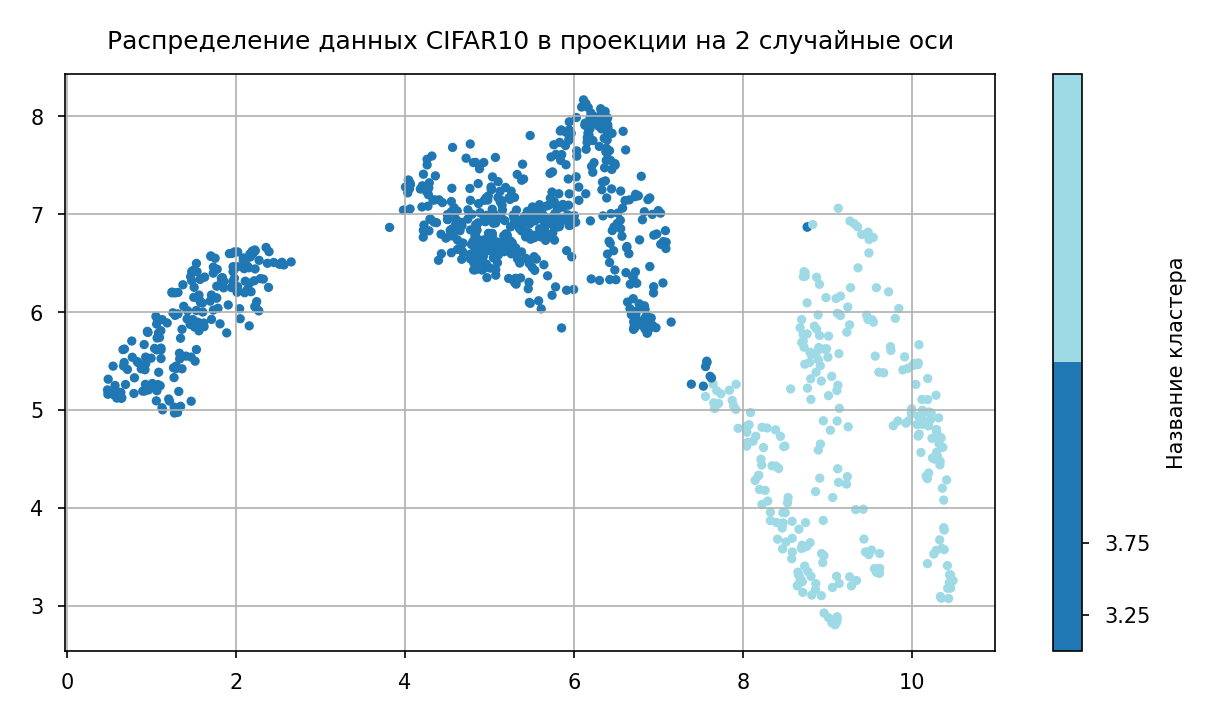

In [ ]:
model_kwargs = {
    'C': best_params['C'],
    'n_clusters': best_params['n_clusters']
}
reducer_kwargs = {
    'n_components': best_params['n_components'],
    'metric': best_params['metric']
}

SumeSupervisedModel = MetaSemiSupervisedModel(
    data_processing='UMAP',
    model=best_params['model_name'],
    reducer_kwargs=reducer_kwargs,
    model_kwargs=model_kwargs
)

SumeSupervisedModel.fit(mnist_data_train, mnist_labels_train),
preds = SumeSupervisedModel.predict(mnist_data_test)

plot_interactive(
    SumeSupervisedModel.processed_data_test,
    mnist_images_test,
    preds,
    image_scale=0.5
)

#### **Задание 1.4 [код]** 

Разбейте выборку следующим образом:
1. Разбейте случайным образом обучающую выборку на 2 части — размеченную и неразмеченную. Считайте, что доля размеченных объектов — `fraction_of_labeled`. Метки неразмеченной части замените на $-1$.
2. Тестовую выборку разбейте в соотношении $30$ на $70$ — меньшую часть (далее будет называться **валидационной выборкой**) используйте для подбора гиперпараметров, а большую (**тестовая выборка**) для итоговой оценки качества.

In [11]:
mnist_test_dataset = MNIST('./mnist', train=False, download=True)
mnist_train_dataset = MNIST('./mnist', train=True, download=False)

mnist_labels_test = np.array(mnist_test_dataset.targets)
mnist_labels_train = np.array(mnist_train_dataset.targets)

mnist_images_test = mnist_test_dataset.data.numpy()
mnist_images_train = mnist_train_dataset.data.numpy()

mnist_images_test, _, mnist_labels_test, _ = train_test_split(
    mnist_images_test, mnist_labels_test, 
    train_size=mnist_n_objects, stratify=mnist_labels_test, random_state=6886
)
mnist_images_train, _, mnist_labels_train, _ = train_test_split(
    mnist_images_train, mnist_labels_train, 
    train_size=mnist_n_objects, stratify=mnist_labels_train, random_state=6886
)

In [12]:
fraction_of_labeled = 0.01

In [13]:
mnist_images_test, mnist_images_val, mnist_labels_test, mnist_labels_val = train_test_split(
    mnist_images_test, mnist_labels_test, test_size=0.3, stratify=mnist_labels_test, random_state=42
)

mnist_data_test = (mnist_images_test.astype(np.float32) / 255.0).reshape([mnist_images_test.shape[0], -1])
mnist_data_train = (mnist_images_train.astype(np.float32) / 255.0).reshape([mnist_images_train.shape[0], -1])
mnist_data_val = (mnist_images_val.astype(np.float32) / 255.0).reshape([mnist_images_val.shape[0], -1])

objects = list()
objects_amount = len(mnist_data_train)
for i in range(objects_amount):
    objects.append([mnist_data_train[i], mnist_labels_train[i]])
np.random.shuffle(objects)
for i in range(objects_amount):
    if i > int(objects_amount * fraction_of_labeled):
        objects[i][1] = -1
np.random.shuffle(objects)
mnist_data_train = list()
mnist_labels_train = list()
for i in range(objects_amount):
    mnist_data_train.append(objects[i][0])
    mnist_labels_train.append(objects[i][1])

#### **Задание 1.5 [кросспроверка, 3 балла][код]** 

Используя MetaSemiSupervisedModel подберите оптимальные параметры:

* `C` — не менее $15$ точек в диапазоне $5-6$ десятичных порядков
* `n_clusters` — не менее $10$ точек вплоть до $100$
* `n_components` — не менее $7$ точек вплоть до $100$

для следующих моделей:
1. Исходные признаки + `LogisticRegression`
2. Исходные признаки + `SelfTrainingClassifier`
3. Исходные признаки + `KMeansClassifier`
4. `UMAP` + `LogisticRegression`
5. `UMAP` + `SelfTrainingClassifier`
6. `UMAP` + `KMeansClassifier`

Подбор каждого гиперпараметра должен быть сопровождён графиками точности на тестовой и валидационной выборках. Изобразите обе линии на одном графике.

При переборе **обязательно выводите значение найденного оптимального параметра и качество модели с оптимальным гиперпараметром** на выборке для итоговой оценки качества.

В последних трёх моделях используйте гиперпараметры базовых моделей, найденные в первых трёх моделях.

In [14]:
best_params_2 = {
    'UMAP': {
        'LogisticRegression': {
            'C': None,
            'n_components': None
        },
        'KMeansClassifier': {
            'n_components': None,
            'n_clusters': None
        },
        'SelfTrainingClassifier': {
            'C': None,
            'n_components': None
        }
    },
    'None': {
        'LogisticRegression': {
            'C': None
        },
        'KMeansClassifier': {
            'n_clusters': None
        },
        'SelfTrainingClassifier': {
            'C': None
        }
    }
}

In [ ]:
def SemiSupervised_updater(
    train_data, labels, test_data,
    model_name, n_clusters, max_iter, C, 
    n_components, metric, data_processing
):
    
    model_kwargs = {
        'C': C,
        'n_clusters': n_clusters
    }
    reducer_kwargs = {
        'n_components': n_components,
        'metric': metric
    }
    
    if data_processing == 'None':
        put_data_processing = None
    else:
        put_data_processing = data_processing

    SumeSupervisedModel = MetaSemiSupervisedModel(
        data_processing=put_data_processing,
        model=model_name,
        reducer_kwargs=reducer_kwargs,
        model_kwargs=model_kwargs
    )

    SumeSupervisedModel.fit(train_data, labels),
    preds = SumeSupervisedModel.predict(test_data)

    if data_processing == 'None':
        best_params_2['UMAP'][model_name]['n_components'] = n_components
        if model_name == 'KMeans':
            best_params_2['UMAP'][model_name]['n_clusters'] = n_clusters
        else:
            best_params_2['None'][model_name]['C'] = C
    else:
        if model_name in ['KMeans']:
            best_params_2['None'][model_name]['n_clusters'] = n_clusters
        else:
            best_params_2['None'][model_name]['C'] = C

    plot_interactive(
        SumeSupervisedModel.processed_data_test,
        mnist_images_test,
        preds,
        image_scale=0.5
    )


interactive_SemiSupervised = interactive(
    SemiSupervised_updater, train_data=fixed(mnist_data_train), labels=fixed(mnist_labels_train), test_data=fixed(mnist_data_test),
    n_clusters=IntSlider(value=12, min=2, max=102, step=5, descrption=r'n_clusters'),
    max_iter=IntSlider(value=700, min=200, max=1200, step=50, descrption=r'max_iter'),
    C=[0.0001, 0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    model_name=['KMeansClassifier', 'SelfTrainingClassifier', 'LogisticRegression'],
    n_components=IntSlider(value=30, min=10, max=100, step=5, descrption=r'n_components'),
    metric=['precomputed', 'cosine', 'euclidean', 'manhattan'],
    data_processing=['UMAP', 'None']
)
interactive_SemiSupervised

interactive(children=(Dropdown(description='model_name', options=('KMeansClassifier', 'SelfTrainingClassifier'…

In [15]:
from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score

In [52]:
from torch import fmax
def SearchParams(model_name, data_preprocessing, add_param=None):
    trials = Trials()
    f1_score_training_val = list()
    f1_score_training_test = list()
    score_parameters = list()

    def quality(parameters):
        if not add_param is None:
            if model_name == 'KMeansClassifier':
                key = 'n_clusters'
                model_kwargs = {
                    key: add_param
                }
            else:
                key = 'C'
                model_kwargs = {
                    key: add_param
                }
        else:
            model_kwargs = dict()
        reducer_kwargs = {
            'metric': 'precomputed'
        }
        for parameter in parameters.keys():
            if parameter == 'n_clusters':
                model_kwargs['n_clusters'] = int(parameters['n_clusters'])
                score_parameters.append(int(parameters['n_clusters']))
            elif parameter == 'n_components':
                reducer_kwargs['n_components'] = int(parameters['n_components'])
                score_parameters.append(int(parameters['n_components']))
            elif parameter == 'C':
                model_kwargs['C'] = float(parameters['C'])
                score_parameters.append(parameters['C'])
        
        if data_preprocessing is None:
            SemiSupervisedModel = MetaSemiSupervisedModel(
                data_processing=None,
                model=model_name,
                reducer_kwargs=reducer_kwargs,
                model_kwargs=model_kwargs
            )
        else:
            SemiSupervisedModel = MetaSemiSupervisedModel(
                data_processing='UMAP',
                model=model_name,
                reducer_kwargs=reducer_kwargs,
                model_kwargs=model_kwargs
            )

        SemiSupervisedModel.fit(np.array(mnist_data_train, dtype=np.float64), mnist_labels_train)
        preds_val = SemiSupervisedModel.predict(np.array(mnist_data_val, dtype=np.float64))
        preds_test = SemiSupervisedModel.predict(np.array(mnist_data_test, dtype=np.float64))

        f1_score_round_val = f1_score(mnist_labels_val, preds_val, average='micro')
        f1_score_round_test = f1_score(mnist_labels_test, preds_test, average='micro')

        f1_score_training_val.append(f1_score_round_val)
        f1_score_training_test.append(f1_score_round_test)

        return 1 - f1_score_round_val

    if data_preprocessing is None:
        if model_name == 'KMeansClassifier':
            parameters_grid = {
                'n_clusters': hp.quniform('n_clusters', 10, 100, 1)
            }
        elif model_name in ['SelfTrainingClassifier', 'LogisticRegression']:
            parameters_grid = {
                'C': hp.uniform('C', 100000, 1000000)
            }
    else:
        if model_name == 'KMeansClassifier':
            parameters_grid = {
                'n_components': hp.quniform('n_components', 7, 100, 1)
            }
        elif model_name in ['SelfTrainingClassifier', 'LogisticRegression']:
            parameters_grid = {
                'n_components': hp.quniform('n_components', 7, 100, 1)
            }
    
    if data_preprocessing is None:
        evals = 16 if model_name == 'KMeansClassifier' else 30
    else:
        evals = 12 if model_name == 'KMeansClassifier' else 18
    best = fmin(
        fn=quality,
        space=parameters_grid,
        algo=tpe.suggest,
        max_evals=evals,
        trials=trials,
        verbose=1
    )

    return best, trials, f1_score_training_test, f1_score_training_val, score_parameters

In [17]:
best_kmeans_non_umap, trials_kmeans_non_umap, f1_kmeans_non_umap_test, f1_kmeans_non_umap_val, score_parameters_kmeans_non_umap  = SearchParams('KMeansClassifier', None)
best_params_2['None']['KMeansClassifier']['n_clusters'] = int(best_kmeans_non_umap['n_clusters'])
best_params_2['UMAP']['KMeansClassifier']['n_clusters'] = int(best_kmeans_non_umap['n_clusters'])

100%|██████████| 16/16 [08:24<00:00, 31.53s/trial, best loss: 0.5283333333333333]


In [53]:
best_logreg_non_umap, trials_logreg_non_umap, f1_logreg_non_umap_test, f1_logreg_non_umap_val, score_parameters_logreg_non_umap = SearchParams('LogisticRegression', None)
best_params_2['None']['LogisticRegression']['C'] = best_logreg_non_umap['C']
best_params_2['UMAP']['LogisticRegression']['C'] = best_logreg_non_umap['C']

100%|██████████| 30/30 [00:06<00:00,  4.30trial/s, best loss: 0.4041666666666667]


In [54]:
best_selftrain_non_umap, trials_selftrain_non_umap, f1_selftrain_non_umap_test, f1_selftrain_non_umap_val, score_parameters_selftrain_non_umap = SearchParams('SelfTrainingClassifier', None)
best_params_2['None']['SelfTrainingClassifier']['C'] = best_selftrain_non_umap['C']
best_params_2['UMAP']['SelfTrainingClassifier']['C'] = best_selftrain_non_umap['C']

100%|██████████| 30/30 [05:50<00:00, 11.67s/trial, best loss: 0.4175]


In [20]:
best_kmeans_umap, trials_kmeans_umap, f1_kmeans_umap_test, f1_kmeans_umap_val, score_parameters_kmeans_umap = SearchParams('KMeansClassifier', 'UMAP', best_params_2['UMAP']['KMeansClassifier']['n_clusters'])
best_params_2['UMAP']['KMeansClassifier']['n_components'] = int(best_kmeans_umap['n_components'])

100%|██████████| 12/12 [16:08<00:00, 80.71s/trial, best loss: 0.7]


In [55]:
best_logreg_umap, trials_logreg_umap, f1_logreg_umap_test, f1_logreg_umap_val, score_parameters_logreg_umap = SearchParams('LogisticRegression', 'UMAP', best_params_2['UMAP']['LogisticRegression']['C'])
best_params_2['UMAP']['LogisticRegression']['n_components'] = best_logreg_umap['n_components']

100%|██████████| 18/18 [24:15<00:00, 80.85s/trial, best loss: 0.7366666666666667]


In [56]:
best_selftrain_umap, trials_selftrain_umap, f1_selftrain_umap_test, f1_selftrain_umap_val, score_parameters_selftrain_umap = SearchParams('SelfTrainingClassifier', 'UMAP', best_params_2['UMAP']['SelfTrainingClassifier']['C'])
best_params_2['UMAP']['SelfTrainingClassifier']['n_components'] = best_selftrain_umap['n_components']

100%|██████████| 18/18 [26:19<00:00, 87.75s/trial, best loss: 0.6975]


In [57]:
f1_kmeans_non_umap = list(zip(f1_kmeans_non_umap_test, f1_kmeans_non_umap_val, score_parameters_kmeans_non_umap))
f1_logreg_non_umap = list(zip(f1_logreg_non_umap_test, f1_logreg_non_umap_val, score_parameters_logreg_non_umap))
f1_selftrain_non_umap = list(zip(f1_selftrain_non_umap_test, f1_selftrain_non_umap_val, score_parameters_selftrain_non_umap))
f1_kmeans_umap = list(zip(f1_kmeans_umap_test, f1_kmeans_umap_val, score_parameters_kmeans_umap))
f1_logreg_umap = list(zip(f1_logreg_umap_test, f1_logreg_umap_val, score_parameters_logreg_umap))
f1_selftrain_umap = list(zip(f1_selftrain_umap_test, f1_selftrain_umap_val, score_parameters_selftrain_umap))

In [58]:
f1_kmeans_non_umap = sorted(f1_kmeans_non_umap, key=lambda x: x[2])
f1_logreg_non_umap = sorted(f1_logreg_non_umap, key=lambda x: x[2])
f1_selftrain_non_umap = sorted(f1_selftrain_non_umap, key=lambda x: x[2])
f1_kmeans_umap = sorted(f1_kmeans_umap, key=lambda x: x[2])
f1_logreg_umap = sorted(f1_logreg_umap, key=lambda x: x[2])
f1_selftrain_umap = sorted(f1_selftrain_umap, key=lambda x: x[2])

In [59]:
def reveal_ziplist3(ziplist):
    lst1, lst2, lst3 = list(), list(), list()
    for ziplist_part in ziplist:
        lst1.append(ziplist_part[0])
        lst2.append(ziplist_part[1])
        lst3.append(ziplist_part[2])
    
    return lst1, lst2, lst3

f1_kmeans_non_umap_test, f1_kmeans_non_umap_val, score_parameters_kmeans_non_umap = reveal_ziplist3(f1_kmeans_non_umap)
f1_logreg_non_umap_test, f1_logreg_non_umap_val, score_parameters_logreg_non_umap = reveal_ziplist3(f1_logreg_non_umap)
f1_selftrain_non_umap_test, f1_selftrain_non_umap_val, score_parameters_selftrain_non_umap = reveal_ziplist3(f1_selftrain_non_umap)
f1_kmeans_umap_test, f1_kmeans_umap_val, score_parameters_kmeans_umap = reveal_ziplist3(f1_kmeans_umap)
f1_logreg_umap_test, f1_logreg_umap_val, score_parameters_logreg_umap = reveal_ziplist3(f1_logreg_umap)
f1_selftrain_umap_test, f1_selftrain_umap_val, score_parameters_selftrain_umap = reveal_ziplist3(f1_selftrain_umap)

In [60]:
best_n_clusters_idx = np.argmax((np.array(f1_kmeans_non_umap_val) + np.array(f1_kmeans_non_umap_test)) / 2)
best_n_clusters = score_parameters_kmeans_non_umap[best_n_clusters_idx]

best_C1_idx = np.argmax((np.array(f1_logreg_non_umap_val) + np.array(f1_logreg_non_umap_test)) / 2)
best_C1 = score_parameters_logreg_non_umap[best_C1_idx]

best_C2_idx = np.argmax((np.array(f1_selftrain_non_umap_val) + np.array(f1_selftrain_non_umap_test)) / 2)
best_C2 = score_parameters_selftrain_non_umap[best_C2_idx]

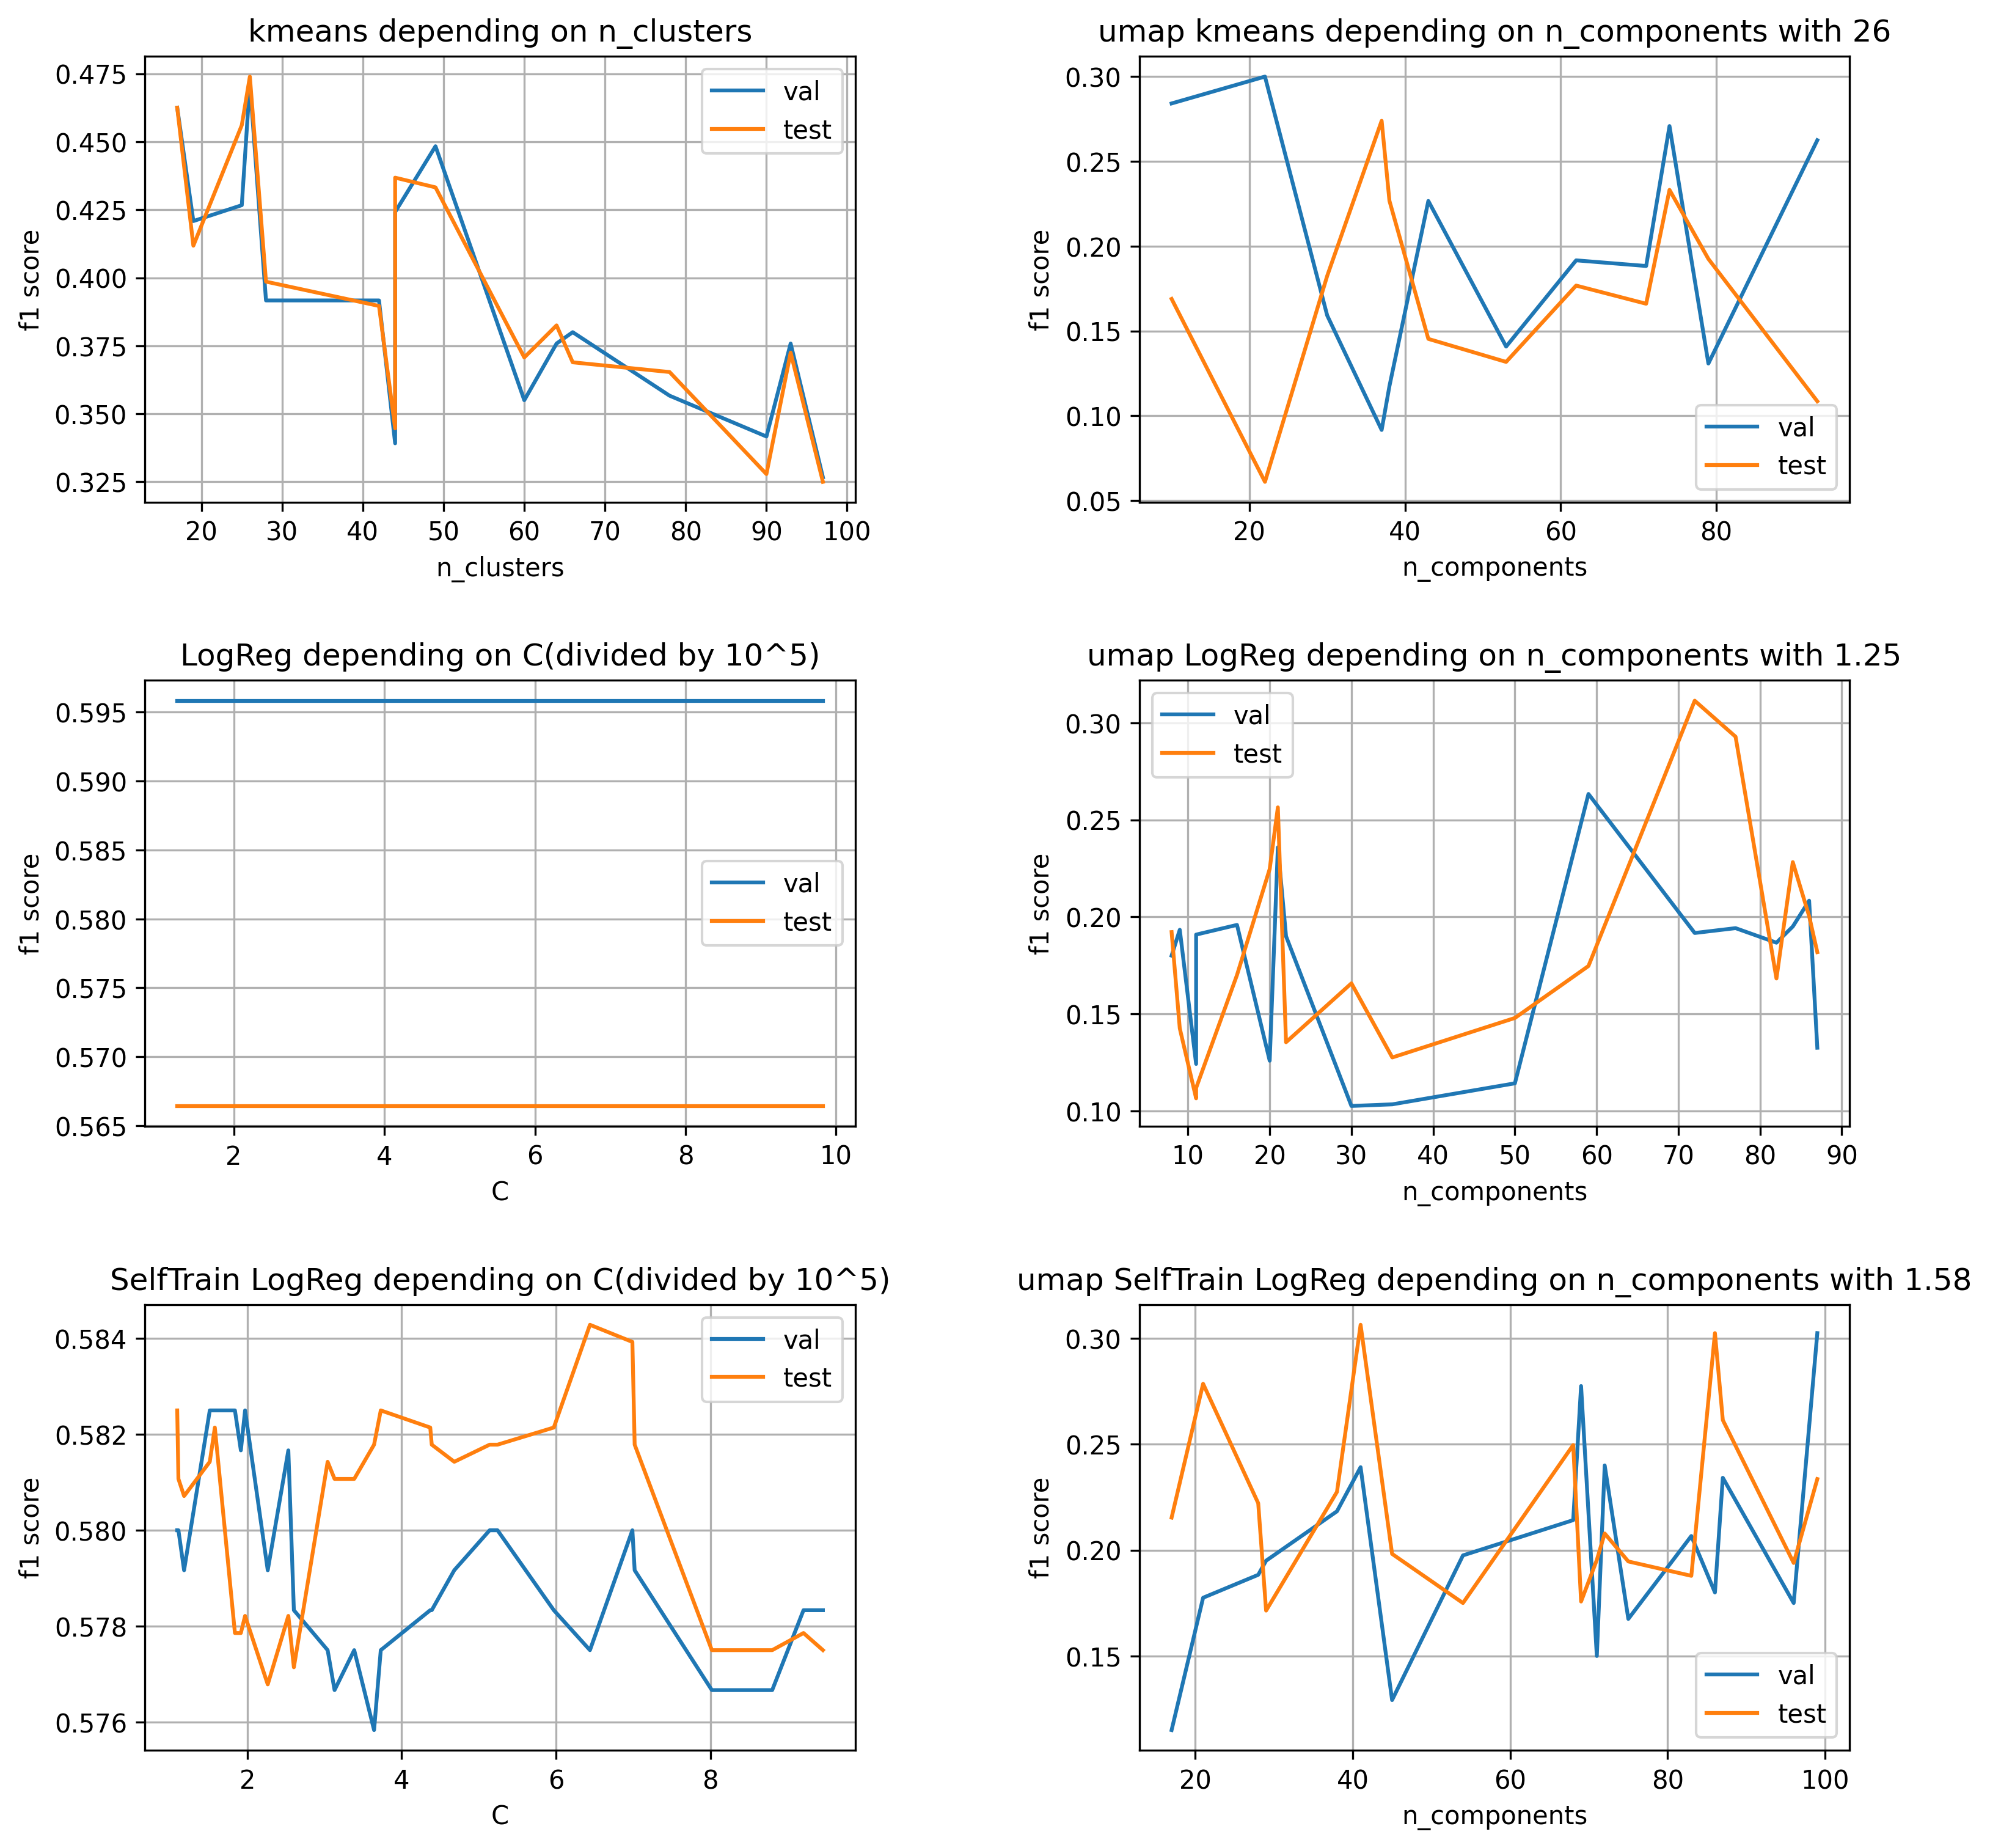

In [66]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

axes[0][0].plot(score_parameters_kmeans_non_umap, f1_kmeans_non_umap_val, label='val')
axes[0][0].plot(score_parameters_kmeans_non_umap, f1_kmeans_non_umap_test, label='test')
axes[0][0].set_title('kmeans depending on n_clusters')
axes[0][0].set_xlabel('n_clusters')
axes[0][0].set_ylabel('f1 score')
axes[0][0].grid(True)
axes[0][0].legend()

axes[0][1].plot(score_parameters_kmeans_umap, f1_kmeans_umap_val, label='val')
axes[0][1].plot(score_parameters_kmeans_umap, f1_kmeans_umap_test, label='test')
axes[0][1].set_title('umap kmeans depending on n_components with ' + f'{best_n_clusters}')
axes[0][1].set_xlabel('n_components')
axes[0][1].set_ylabel('f1 score')
axes[0][1].grid(True)
axes[0][1].legend()

axes[1][0].plot(np.array(score_parameters_logreg_non_umap) / 10 ** 5, f1_logreg_non_umap_val, label='val')
axes[1][0].plot(np.array(score_parameters_logreg_non_umap) / 10 ** 5, f1_logreg_non_umap_test, label='test')
axes[1][0].set_title('LogReg depending on C(divided by 10^5)')
axes[1][0].set_xlabel('C')
axes[1][0].set_ylabel('f1 score')
axes[1][0].grid(True)
axes[1][0].legend()

axes[1][1].plot(score_parameters_logreg_umap, f1_logreg_umap_val, label='val')
axes[1][1].plot(score_parameters_logreg_umap, f1_logreg_umap_test, label='test')
axes[1][1].set_title('umap LogReg depending on n_components with ' + f'{round(best_C1 / 10 ** 5, 2)}')
axes[1][1].set_xlabel('n_components')
axes[1][1].set_ylabel('f1 score')
axes[1][1].grid(True)
axes[1][1].legend()

axes[2][0].plot(np.array(score_parameters_selftrain_non_umap) / 10 ** 5, f1_selftrain_non_umap_val, label='val')
axes[2][0].plot(np.array(score_parameters_selftrain_non_umap) / 10 ** 5, f1_selftrain_non_umap_test, label='test')
axes[2][0].set_title('SelfTrain LogReg depending on C(divided by 10^5)')
axes[2][0].set_xlabel('C')
axes[2][0].set_ylabel('f1 score')
axes[2][0].grid(True)
axes[2][0].legend()

axes[2][1].plot(score_parameters_selftrain_umap, f1_selftrain_umap_val, label='val')
axes[2][1].plot(score_parameters_selftrain_umap, f1_selftrain_umap_test, label='test')
axes[2][1].set_title('umap SelfTrain LogReg depending on n_components with ' + f'{round(best_C2 / 10 ** 5, 2)}')
axes[2][1].set_xlabel('n_components')
axes[2][1].set_ylabel('f1 score')
axes[2][1].grid(True)
axes[2][1].legend()

plt.show()

#### **Задание 1.6 [кросспроверка, 3 балла][вопрос]** 

Опишите полученные результаты. Какая модель проявила себя лучше всего? Как влияет на результат снижение размерности признакового пространства?

Лучше всего себя показал SelfTraining и использованием Логистической регрессии и сама Логистическая регрессия, само же уменьшение признакового пространства не особо нам помогло, а наоборот ухудшило результат.

#### **Задание 1.7 [кросспроверка, 2 балла][код]** 

Обучите каждую из шести моделей на выборках с разной долей размеченных объектов. Используйте оптимальные параметры из предыдущего пункта. Изобразите итоговое качество в зависимости от доли размеченных объектов для всех моделей на одном графике. 

Используйте сетку для перебора, указанную ниже. При желании можете взять больше точек.

In [68]:
fraction_of_labeled_range = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 0.99]

In [70]:
models = [
    'KMeansClassifier', 
    'LogisticRegression',
    'SelfTrainingClassifier',
    'umap_KMeansClassifier',
    'umap_LogisticRegression',
    'umap_SelfTrainingClassifier'
]
f1_scores_fractions = list()

for model in models:
    f1_score_eval_fraction_model = list()
    for fraction in fraction_of_labeled_range:
        mnist_test_dataset = MNIST('./mnist', train=False, download=True)
        mnist_train_dataset = MNIST('./mnist', train=True, download=False)

        mnist_labels_test = np.array(mnist_test_dataset.targets)
        mnist_labels_train = np.array(mnist_train_dataset.targets)

        mnist_images_test = mnist_test_dataset.data.numpy()
        mnist_images_train = mnist_train_dataset.data.numpy()

        mnist_images_test, _, mnist_labels_test, _ = train_test_split(
            mnist_images_test, mnist_labels_test, 
            train_size=mnist_n_objects, stratify=mnist_labels_test, random_state=6886
        )
        mnist_images_train, _, mnist_labels_train, _ = train_test_split(
            mnist_images_train, mnist_labels_train, 
            train_size=mnist_n_objects, stratify=mnist_labels_train, random_state=6886
        )

        mnist_images_test, mnist_images_val, mnist_labels_test, mnist_labels_val = train_test_split(
            mnist_images_test, mnist_labels_test, test_size=0.3, stratify=mnist_labels_test, random_state=42
        )

        mnist_data_test = (mnist_images_test.astype(np.float32) / 255.0).reshape([mnist_images_test.shape[0], -1])
        mnist_data_train = (mnist_images_train.astype(np.float32) / 255.0).reshape([mnist_images_train.shape[0], -1])
        mnist_data_val = (mnist_images_val.astype(np.float32) / 255.0).reshape([mnist_images_val.shape[0], -1])

        objects = list()
        objects_amount = len(mnist_data_train)
        for i in range(objects_amount):
            objects.append([mnist_data_train[i], mnist_labels_train[i]])
        np.random.shuffle(objects)
        for i in range(objects_amount):
            if i > int(objects_amount * fraction):
                objects[i][1] = -1
        np.random.shuffle(objects)
        mnist_data_train = list()
        mnist_labels_train = list()
        for i in range(objects_amount):
            mnist_data_train.append(objects[i][0])
            mnist_labels_train.append(objects[i][1])
        
        reducer_kwargs = {
            'metric': 'precomputed'
        }
        if 'umap' in model:
            model_name = model[5:]
            reducer_kwargs['n_components'] = best_params_2['UMAP'][model_name]['n_components']
            if model_name == 'KMeansClassifier':
                param = 'n_clusters'
            else:
                param = 'C'
            model_kwargs = {
                param: best_params_2['UMAP'][model_name][param]
            }
            SemiSupervisedModel = MetaSemiSupervisedModel(
                data_processing='UMAP',
                model=model_name,
                reducer_kwargs=reducer_kwargs,
                model_kwargs=model_kwargs
            )
        else:
            model_name = model
            if model_name == 'KMeansClassifier':
                param = 'n_clusters'
            else:
                param = 'C'
            model_kwargs = {
                param: best_params_2['UMAP'][model_name][param]
            }
            SemiSupervisedModel = MetaSemiSupervisedModel(
                data_processing='None',
                model=model_name,
                reducer_kwargs=reducer_kwargs,
                model_kwargs=model_kwargs
            )
        
        SemiSupervisedModel.fit(np.array(mnist_data_train, dtype=np.float64), mnist_labels_train)
        preds_test = SemiSupervisedModel.predict(np.array(mnist_data_test, dtype=np.float64))

        f1_score_model_fraction = f1_score(mnist_labels_test, preds_test, average='micro')

        f1_score_eval_fraction_model.append(f1_score_model_fraction)
    f1_scores_fractions.append(f1_score_eval_fraction_model)

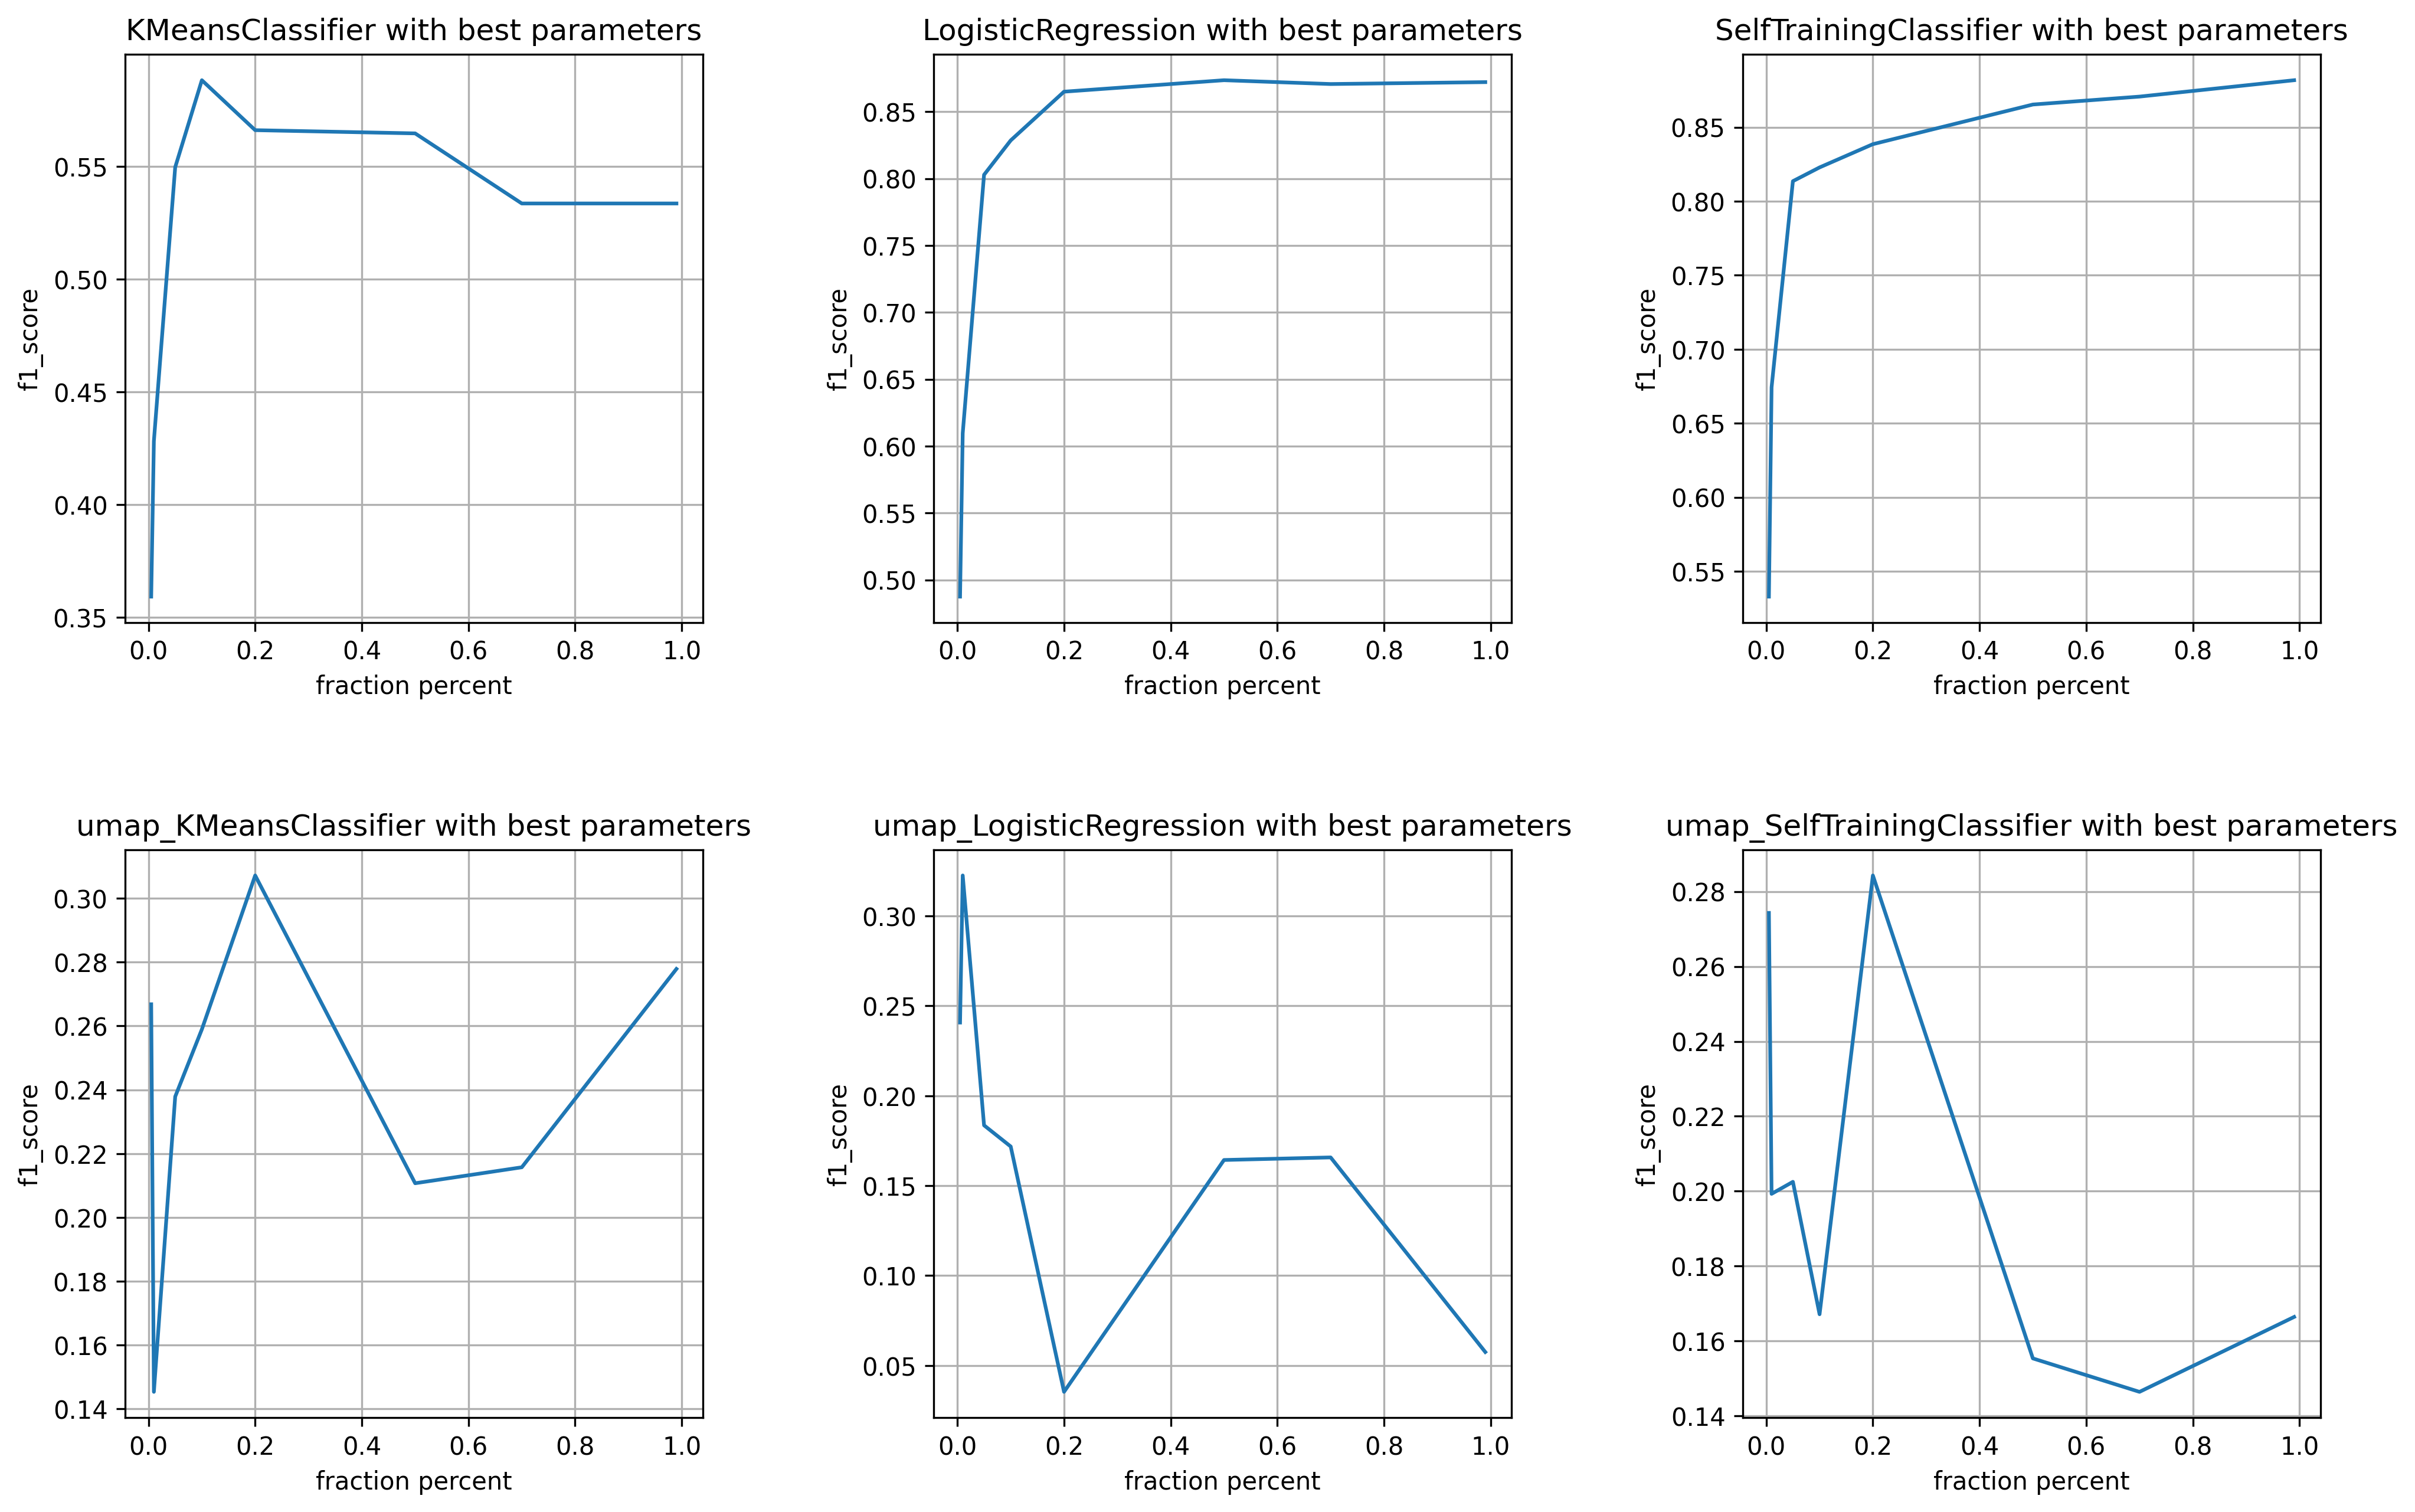

In [88]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
zip_model_results = list(zip(models, f1_scores_fractions))

for idx, pair in enumerate(zip_model_results):
    model_name = pair[0]
    f1_scores_fraction = pair[1]
    axes[idx // 3][idx % 3].plot(fraction_of_labeled_range, f1_scores_fraction)
    axes[idx // 3][idx % 3].grid(True)
    axes[idx // 3][idx % 3].set_ylabel('f1_score')
    axes[idx // 3][idx % 3].set_xlabel('fraction percent')
    axes[idx // 3][idx % 3].set_title(model_name + ' with best parameters')

plt.show()

In [95]:
print('KMeans wthout UMAP best n_clusters', best_kmeans_non_umap)
print()
print('LogReg wthout UMAP best C', best_logreg_non_umap)
print()
print('SelfTrain LogReg wthout UMAP best C', best_selftrain_non_umap)
print()
print('KMeans with UMAP best n_components', best_kmeans_umap)
print()
print('LogReg with UMAP best n_components', best_logreg_umap)
print()
print('SelfTrain LogReg with UMAP best n_components', best_selftrain_umap)

KMeans wthout UMAP best n_clusters {'n_clusters': 26.0}

LogReg wthout UMAP best C {'C': 767236.5882611009}

SelfTrain LogReg wthout UMAP best C {'C': 183970.5249267812}

KMeans with UMAP best n_components {'n_components': 22.0}

LogReg with UMAP best n_components {'n_components': 59.0}

SelfTrain LogReg with UMAP best n_components {'n_components': 99.0}


#### **Задание 1.8 [кросспроверка, 2 балла][вопрос]** 

Как разные модели ведут себя в зависимости от объёма размеченных данных? Какой размер выборки достаточно разметить, чтобы получить близкое к максимальному качество?

В целом модели с UMAP ведут себя плохо на любом проценте размеченных данных, при этом относительно неплохой f1 score удается достичь при малом количестве размеченных данных(20% - 40%). Для моделей без использования UMAP удается достичь весьма высокий f1 score уже при 20% размеченныж данных.